In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cmath
import datetime
from scipy.linalg import expm

In [2]:
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor
from qutip.qip.algorithms import qft
from qutip import *
#import qutip.logging_utils as logging
#logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
#log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen

example_name = 'QFT'

In [3]:
b  = qutip.Bloch()

#Vizualising Blch sphere
#b.make_sphere()
b.view = [90,0]
b.clear()

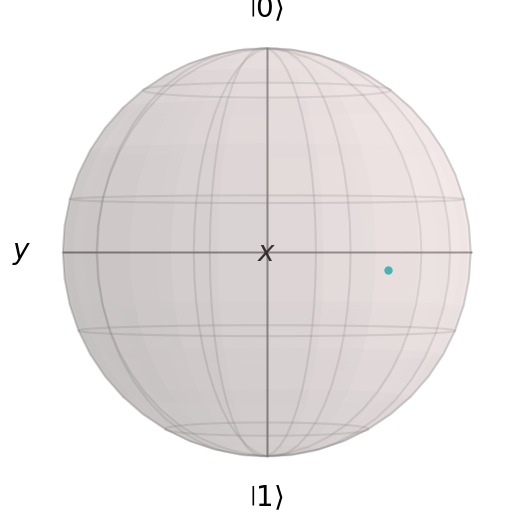

In [4]:

# b.make_sphere()
def plot(rho, num):
    eigenvalues, eigenvectors = np.linalg.eig(rho.full())
    idx = eigenvalues.argsort()[::-1]  # Sort by eigenvalue in descending order
    eigenvectors = eigenvectors[:, idx]  # Sort eigenvectors accordingly
    dominant_eigenvector = eigenvectors[:, 0]
    state = Qobj(dominant_eigenvector / np.linalg.norm(dominant_eigenvector))

    bloch_vector = [
        expect(sigmax(), state),
        expect(sigmay(), state),
        expect(sigmaz(), state)
    ]

    if(num==0):
        state=state.full()
        b.add_points(np.array(bloch_vector)[:, np.newaxis], 'm','c')
        b.render()
    #
    else:
        b.add_states(state)
        b.render()

# b.make_sphere()
rho = Qobj(np.array([[-9,10],[-12,8]]))#this is the input
plot(rho,0)# if second parameter = 0, it will plot a point, if 1 it will plot a vector
b.show()

In [5]:
# everything is in units of MHz
f_1 = 5.03103*(10**3)
f_2 = 4.92672*(10**3)
f_3 = 5.03648*(10**3)
f_4 = 4.96961*(10**3)
f_5 = 4.83780*(10**3)
f_6 = 4.92466*(10**3)
delta_1 = -271
delta_2 = -269
delta_3 = -268
delta_4 = -269
delta_5 = -280
delta_6 = -271
# all the times (T) are in microseconds. Therefore, 1/T would be in MHz. [NOT INCLUDED rn.]
T1_1 = 44
T1_2 = 30
T1_3 = 25
T1_4 = 37
T1_5 = 1.6
T1_6 = 57
T2star_1 = 35
T2star_2 = 21
T2star_3 = 11
T2star_4 = 28
T2star_5 = 2.2
T2star_6 = 26
T2_1 = 40
T2_2 = 42
T2_3 = 27
T2_4 = 30
T2_5 = 2
T2_6 = 28


In [6]:
1/((1/T2_2)-(1/(2*T1_2)))

140.00000000000003

In [10]:
# no. of levels for each transmon.
N = 3

# defines a_i.
a_1 = tensor(destroy(N), qeye(N), qeye(N), qeye(N), qeye(N), qeye(N))
a_2 = tensor(qeye(N), destroy(N), qeye(N), qeye(N), qeye(N), qeye(N))
a_3 = tensor(qeye(N), qeye(N), destroy(N), qeye(N), qeye(N), qeye(N))
a_4 = tensor(qeye(N), qeye(N), qeye(N), destroy(N), qeye(N), qeye(N))
a_5 = tensor(qeye(N), qeye(N), qeye(N), qeye(N), destroy(N), qeye(N))
a_6 = tensor(qeye(N), qeye(N), qeye(N), qeye(N), qeye(N), destroy(N))
# defines a list of a_i's for all 6 qubits.
a = [a_1, a_2, a_3, a_4, a_5, a_6]

# defines the identity matrix
identity_matrix = tensor(qeye(N), qeye(N), qeye(N), qeye(N), qeye(N), qeye(N))
# defines the zero matrix
zero_ = Qobj(np.zeros((N,N)))
zero_matrix = tensor(zero_, zero_, zero_, zero_, zero_, zero_)

In [11]:
# the lists of variables for all 6 qubits.
f = [f_1, f_2, f_3, f_4, f_5, f_6] #the coefficient of the bare hamiltonian for each qubit
delta = [delta_1, delta_2, delta_3, delta_4, delta_5, delta_6] #the coefficient for the Kerr term
T1 = [T1_1, T1_2, T1_3, T1_4, T1_5, T1_6] 
T2star = [T2star_1, T2star_2, T2star_3, T2star_4, T2star_5, T2star_6]
T2 = [T2_1, T2_2, T2_3, T2_4, T2_5, T2_6]
#      11    12    13   14    15    16     21   22    23   24    25    26      31    32   33    34   35    36     41   42    43   44    45    46       51    52    53    54    55   56     61    62    63    64    65    66
J = [[ 0.0, 4.03, 0.57, 2.8, 0.82, 2.09],[4.03, 0.0, 3.88, 0.5, 3.26, 0.51],[ 0.57, 3.88, 0.0, 4.25, 0.17, 3.02],[ 2.8, 0.5, 4.25, 0.0, 3.34, 0.41],[ 0.82, 3.26, 0.17, 3.34, 0.0, 2.62],[ 2.09, 0.51, 3.02, 0.41, 2.62, 0.0]]

In [33]:
def Hamiltonian(f, delta, J, N):
    
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(6):
        e = (f[i]-f[0])*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + 2*np.pi*e
       
    # defines the interaction Hamiltonian (the spins are labelled 0-5)
    H_int = zero_matrix
    for i in range(6):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%6])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%6]) + Qobj(a[i])*Qobj(a[(i+1)%6]).dag()) #(J[i][(i + 1)%6])*(Qobj(a[i]).dag() + Qobj(a[i]))*(Qobj(a[(i+1)%6]).dag() +  Qobj(a[(i+1)%6]))
        # defines the interaction with the next neighbour on the left of the ith spin - which is the ((i-1) mod 6)-th spin.
        p_neighbor_2 = (J[i][(i - 1)%6])*(Qobj(a[i]).dag()*Qobj(a[(i-1)%6]) + Qobj(a[i])*Qobj(a[(i-1)%6]).dag()) #(J[i][(i - 1)%6])*(Qobj(a[i]).dag() + Qobj(a[i]))*(Qobj(a[(i-1)%6]).dag() +  Qobj(a[(i-1)%6]))
        # defines the interaction with the spin diagonally opposite to the ith spin - which is the ((i + 3) mod 6)-th spin.
        p_diag = (J[i][(i + 3)%6])*(Qobj(a[i]).dag()*Qobj(a[(i+3)%6]) + Qobj(a[i])*Qobj(a[(i+3)%6]).dag()) #(J[i][(i + 3)%6])*(Qobj(a[i]).dag() + Qobj(a[i]))*(Qobj(a[(i+3)%6]).dag() +  Qobj(a[(i+3)%6]))
        H_int = H_int + 2*np.pi*0.5*(p_neighbor_1 + p_neighbor_2 + p_diag) #to prevent double counting, we need to multiply by 0.5.
        
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham
H_d = Hamiltonian(f, delta, J, N)
H_c = [(2*np.pi)*Qobj(a[0].dag() + a[0])/2]
n_ctrls = len(H_c)

# start point for the gate evolution
U_0 = identity_matrix
# Target for the gate evolution - Quantum Fourier Transform gate
from qutip.qip.operations import cnot
#U_targ = Qobj(a[0].dag() + a[0])
H_d

Quantum object: dims=[[3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3]], shape=(729, 729), type='oper', dtype=Dense, isherm=True
Qobj data =
[[     0.              0.              0.         ...      0.
       0.              0.        ]
 [     0.           -668.34242112      0.         ...      0.
       0.              0.        ]
 [     0.              0.          -3039.4280605  ...      0.
       0.              0.        ]
 ...
 [     0.              0.              0.         ... -12968.62013772
       0.              0.        ]
 [     0.              0.              0.         ...      0.
  -13636.96255885      0.        ]
 [     0.              0.              0.         ...      0.
       0.         -16008.04819822]]

In [13]:
ggg=[0.0012864741843387347, 0.0034969993980696547, 0.008506190349491677, 0.018514828519579474, 0.036061961771874894, 0.06285271768057651, 0.09802657538307226, 0.13680710659325385, 0.17085140034037768, 0.1909296978016222, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1909296978016222, 0.17085140034037768, 0.13680710659325385, 0.09802657538307226, 0.06285271768057651, 0.036061961771874894, 0.018514828519579474, 0.008506190349491677, 0.0034969993980696547, 0.0012864741843387347]
print(ggg,12.7*2)

[0.0012864741843387347, 0.0034969993980696547, 0.008506190349491677, 0.018514828519579474, 0.036061961771874894, 0.06285271768057651, 0.09802657538307226, 0.13680710659325385, 0.17085140034037768, 0.1909296978016222, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1936, 0.1909296978016222, 0.17085140034037768, 0.13680710659325385, 0.09802657538307226, 0.06285271768057651, 0.036061961771874894, 0.018514828519579474, 0.008506190349491677, 0.0034969993980696547, 0.0012864741843387347] 25.4


In [14]:
if N==2:
    ux=[[0,1],[1,0]]
else:
    ux=[[0,1,0],[1,0,0],[0,0,1]]

In [15]:
from scipy.linalg import expm
U=identity(N)
for jj in range(1,6):
    U_temp=identity(N)
    for i in range(len(ggg)):
        U_temp=Qobj(expm(-0.001*1j*2*np.pi*(f[jj]-f[0])*((destroy(N).dag()*destroy(N)).full())))*U_temp
    U=tensor(U,U_temp)
U_targ=tensor(Qobj(ux),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))*U

In [16]:
Qobj([[0,1,0],[1,0,0],[0,0,1]])

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]

In [17]:
U_temp=Qobj(expm(-0.001*52*1j*2*np.pi*H_d.full()),dims=[[N,N,N,N,N,N],[N,N,N,N,N,N]])
U_targ=tensor(Qobj(ux),qeye(N),qeye(N),qeye(N),qeye(N),qeye(N))*U_temp


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x000002341ABD87C0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



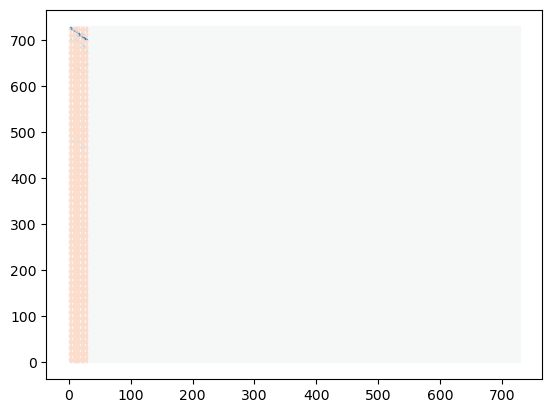

In [18]:
qutip.visualization.hinton(Qobj(np.log(H_d.full()+1e-1),dims=[[N,N,N,N,N,N],[N,N,N,N,N,N]]))
plt.show()
qutip.visualization.hinton(Qobj(np.log(Qobj(a[0].dag() + a[0]).full()+1e-2),dims=[[N,N,N,N,N,N],[N,N,N,N,N,N]]))
plt.show()

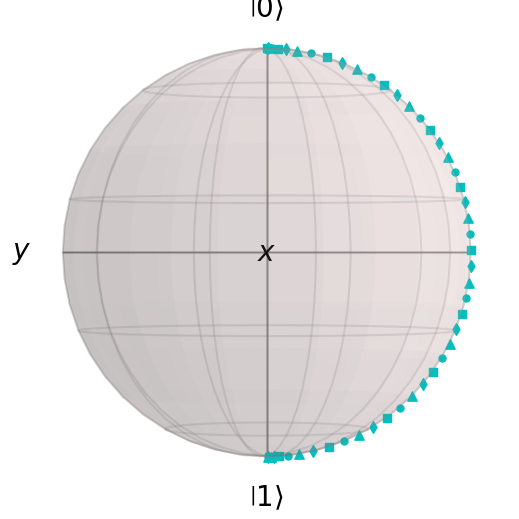

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 9.42647144e-03+0.00000000e+00j -4.92968062e-02+3.88850358e-03j
  -3.46869310e-06+7.22580678e-05j]
 [-4.92968062e-02-3.88850358e-03j  9.90571410e-01+0.00000000e+00j
   1.70334845e-04-1.43845820e-03j]
 [-3.46869310e-06-7.22580678e-05j  1.70334845e-04+1.43845820e-03j
   2.11853573e-06+0.00000000e+00j]]

In [34]:
from scipy.linalg import expm
U=identity(N**6)
U=Qobj(U.full(),dims=[[N,N,N,N,N,N],[N,N,N,N,N,N]])
fid=[]
for i in range(len(ggg)):
    U=Qobj(expm(-0.001*1j*(H_d.full()+(12.65355/0.1936)*ggg[i]*H_c[0].full())),dims=[[N,N,N,N,N,N],[N,N,N,N,N,N]])*U
    U=Qobj(U.full(),dims=[[N,N,N,N,N,N],[N,N,N,N,N,N]])
    U_1=U.ptrace(0)*np.exp(-1j*cmath.polar(U.ptrace(0)[0][1])[1])#/cmath.polar(U.ptrace(0)[0][1])[0]
    U_1=np.sqrt(N)*U_1/np.sqrt((U_1.dag()*U_1).tr())
    #fid.append(np.abs((sigmax()*U_1).tr())/2)
    plot(Qobj(((U*tensor(basis(N, 0),basis(N, 0),basis(N, 0),basis(N, 0),basis(N, 0),basis(N, 0))).ptrace(0)).full()[:2,:2]),0)
#U=U*np.exp(-1j*cmath.polar(U[0][0])[1])
b.show()
b.clear()
(U*tensor(basis(N, 0),basis(N, 0),basis(N, 0),basis(N, 0),basis(N, 0),basis(N, 0))).ptrace(0)

In [42]:
Qobj(((U*tensor(basis(N, 0),basis(N, 0),basis(N, 0),basis(N, 0),basis(N, 0),basis(N, 0))).ptrace(5)).full())

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 9.99651909e-01+0.00000000e+00j -1.51248303e-03+1.00324744e-03j
   6.71720328e-07-4.88444118e-07j]
 [-1.51248303e-03-1.00324744e-03j  3.48091045e-04+0.00000000e+00j
  -1.22950826e-07+1.13701525e-07j]
 [ 6.71720328e-07+4.88444118e-07j -1.22950826e-07-1.13701525e-07j
   8.09452830e-11+0.00000000e+00j]]

In [145]:
U.full()

array([[ 6.50868835e-03+4.84123905e-02j, -3.21108703e-03-1.83326924e-02j,
        -4.88698307e-06+7.53733501e-06j, ...,
         4.12572852e-28-2.23803216e-28j,  4.24892420e-31-1.02773530e-30j,
        -4.62322921e-34+4.08592051e-34j],
       [-3.21108703e-03-1.83326924e-02j,  3.99636272e-03-5.46647574e-02j,
        -4.11674884e-04+7.48873820e-03j, ...,
         1.68525524e-25+2.10563428e-26j,  1.62371709e-28+7.43678490e-28j,
         3.03899459e-31+1.96616166e-31j],
       [-4.88698307e-06+7.53733501e-06j, -4.11674884e-04+7.48873820e-03j,
        -2.59776116e-02+2.26749906e-02j, ...,
         9.13277436e-23+1.13615917e-22j, -2.83802028e-25-5.88789869e-26j,
         5.73781556e-28+4.55279137e-28j],
       ...,
       [ 4.12572852e-28-2.23803216e-28j,  1.68525524e-25+2.10563428e-26j,
         9.13277436e-23+1.13615917e-22j, ...,
        -5.92387468e-01+8.05243795e-01j, -2.44920725e-04+3.30604993e-04j,
        -9.91874871e-08+1.53715981e-07j],
       [ 4.24892420e-31-1.02773530e-30j,  1.

In [174]:
UU=U.ptrace(0)*np.exp(-1j*cmath.polar(U.ptrace(0)[0][1])[1])#/cmath.polar(U.ptrace(0)[0][1])[0]
np.sqrt(N)*UU/np.sqrt((UU.dag()*UU).tr())

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.96352217-0.26762854j 0.        +0.j        ]
 [0.        +0.j         0.96352217-0.26762854j]]

In [16]:
U_1.dag()#*U_1#*np.exp(-1j*cmath.polar(U_1[0][1])[1])

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-1.89832805e-01-3.39731025e-01j  9.73371789e-01+1.42520377e-13j
   5.02227860e-04-1.93023418e-03j]
 [ 9.73371789e-01+5.19957595e-17j  4.55051787e-01+5.15427644e-01j
  -9.10626724e-03-1.26203510e-02j]
 [ 5.02227860e-04-1.93023418e-03j -9.10626724e-03-1.26203510e-02j
   8.49160095e-02-6.87895482e-01j]]

(0.7070118596187852, 0.6934872991258424)

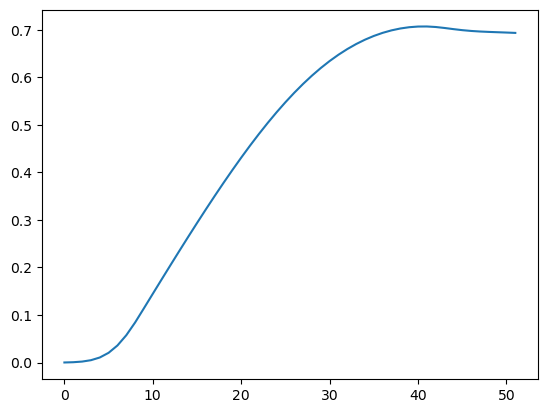

In [30]:
plt.plot(fid)
np.max(fid),fid[-1]

In [153]:
U_targ

Quantum object: dims=[[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]], shape=(64, 64), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]

In [194]:
# Duration of each timeslot
#dt = 0.001
# List of evolution times to try
evo_times = [0.052, 3, 6]
n_evo_times = len(evo_times)
evo_time = evo_times[0]
n_ts = 52#int(float(evo_time) / dt)
#Empty list that will hold the results for each evolution time
results = list()

In [195]:
# Fidelity error target
fid_err_targ = 1e-5
# Maximum iterations for the optisation algorithm
max_iter = 2
# Maximum (elapsed) time allowed in seconds
max_wall_time = 60
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

In [196]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'ZERO'

In [197]:
#Set to None to suppress output files
f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)

In [198]:
optim = cpo.create_pulse_optimizer(H_d, H_c, U_0, U_targ, n_ts, evo_time, 
                amp_lbound=-25.4 , amp_ubound=25.4 , 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                optim_method='fmin_l_bfgs_b',
                method_params={'max_metric_corr':20, 'accuracy_factor':1e8},
                dyn_type='UNIT', 
                fid_params={'phase_option':'PSU'},
                init_pulse_type=p_type, gen_stats=True)

# **** get handles to the other objects ****
optim.test_out_files = 0
dyn = optim.dynamics
dyn.test_out_files = 0
p_gen = optim.pulse_generator

In [199]:
# Generate the tau (duration) and time (cumulative) arrays
    # so that it can be used to create the pulse generator
    # with matching timeslots
dyn.init_timeslots()
# Create a new pulse generator for the new dynamics
p_gen = pulsegen.create_pulse_gen(p_type, dyn)
#p_gen.scaling = 0.2
#p_gen.lbound = -10
#p_gen.ubound = 50*2

#Generate different initial pulses for each of the controls
init_amps = np.zeros([n_ts, n_ctrls])
if (p_gen.periodic):
    phase_diff = np.pi / n_ctrls
    for j in range(n_ctrls):
        init_amps[:, j] = p_gen.gen_pulse(freq=40,start_phase=phase_diff*j)
elif (isinstance(p_gen, pulsegen.PulseGenLinear)):
    for j in range(n_ctrls):
        p_gen.scaling = float(j) - float(n_ctrls - 1)/2
        init_amps[:, j] = p_gen.gen_pulse()
elif (isinstance(p_gen, pulsegen.PulseGenZero)):
    for j in range(n_ctrls):
        p_gen.offset = sf = float(j) - float(n_ctrls - 1)/2
        init_amps[:, j] = p_gen.gen_pulse()
else:
    # Should be random pulse
    for j in range(n_ctrls):
        init_amps[:, j] = p_gen.gen_pulse()
for j in range(int(len(init_amps))):
    init_amps[j, 0] = (12.65355/0.1936)*ggg[j]#p_gen.gen_pulse()
dyn.initialize_controls(init_amps)
len(init_amps),n_ctrls,init_amps

(52,
 1,
 array([[ 0.08408298],
        [ 0.22856124],
        [ 0.55595819],
        [ 1.21011523],
        [ 2.35698263],
        [ 4.10800623],
        [ 6.40694304],
        [ 8.94160932],
        [11.16671868],
        [12.47902106],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.65355   ],
        [12.47902106],
  

In [200]:

    
# Save initial amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_initial_" + f_ext
    dyn.save_amps(pulsefile)
    print("Initial amplitudes output to file: " + pulsefile)

print("***********************************")
print("\n+++++++++++++++++++++++++++++++++++")
print("Starting pulse optimisation for T={}".format(evo_time))
print("+++++++++++++++++++++++++++++++++++\n")
results = optim.run_optimization()

    # Save final amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_final_" + f_ext
    dyn.save_amps(pulsefile)
    print("Final amplitudes output to file: " + pulsefile)
    
# Report the results
#results.stats.report()
#print("Final evolution\n{}\n".format(results.evo_full_final))
print("********* Summary *****************")
print("Final fidelity error {}".format(results.fid_err))
print("Final gradient normal {}".format(results.grad_norm_final))
print("Terminated due to {}".format(results.termination_reason))
print("Number of iterations {}".format(results.num_iter))
print("Completed in {} HH:MM:SS.US".format(
            datetime.timedelta(seconds=results.wall_time)))

Initial amplitudes output to file: ctrl_amps_initial_QFT_n_ts52_ptypeZERO.txt
***********************************

+++++++++++++++++++++++++++++++++++
Starting pulse optimisation for T=0.052
+++++++++++++++++++++++++++++++++++



MemoryError: Unable to allocate 8.11 MiB for an array with shape (729, 729) and data type complex128

In [ ]:
1-results.initial_fid_err

In [ ]:
print(results.final_amps[:,0].shape)
plt.plot(results.time[:-1], results.final_amps[:,0],color = 'black')
plt.plot(results.time[:-1], results.initial_amps[:,0],color = 'green')

plt.tight_layout()
plt.show()

In [20]:
results.initial_amps[:,0],

(array([ 0.08408298,  0.22856124,  0.55595819,  1.21011523,  2.35698263,
         4.10800623,  6.40694304,  8.94160932, 11.16671868, 12.47902106,
        12.65355   , 12.65355   , 12.65355   , 12.65355   , 12.65355   ,
        12.65355   , 12.65355   , 12.65355   , 12.65355   , 12.65355   ,
        12.65355   , 12.65355   , 12.65355   , 12.65355   , 12.65355   ,
        12.65355   , 12.65355   , 12.65355   , 12.65355   , 12.65355   ,
        12.65355   , 12.65355   , 12.65355   , 12.65355   , 12.65355   ,
        12.65355   , 12.65355   , 12.65355   , 12.65355   , 12.65355   ,
        12.65355   , 12.65355   , 12.47902106, 11.16671868,  8.94160932,
         6.40694304,  4.10800623,  2.35698263,  1.21011523,  0.55595819,
         0.22856124,  0.08408298]),)

In [31]:

U=results.evo_full_initial
U_1=np.exp(-1j*cmath.polar(U.ptrace(0)[0][1])[1])*U.ptrace(0)/cmath.polar(U.ptrace(0)[0][1])[0]
U_1

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-2.10968927e-12+3.26067655e-05j  1.00000000e+00+8.77921016e-17j]
 [ 1.00000000e+00-1.31688152e-15j  1.63746566e-12+3.26067606e-05j]]

In [33]:
np.abs(tensor(basis(2, 1),basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0)).dag()*results.evo_full_initial*tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0)))**2

0.9376049845556826

In [34]:
(((results.evo_full_initial*tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))).ptrace(0))*((results.evo_full_initial*tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))).ptrace(0))).tr()

0.8914754831510591

In [32]:
(results.evo_full_initial*tensor(basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0),basis(2, 0))).ptrace(0)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[5.75774184e-02+0.00000000e+00j 9.16048072e-15+2.88519375e-05j]
 [9.16048072e-15-2.88519375e-05j 9.42422582e-01+0.00000000e+00j]]

In [35]:
print(fid[-1])

0.998154345623512


In [38]:
destroy(2).dag()+destroy(2)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dia, isherm=True
Qobj data =
[[0. 1.]
 [1. 0.]]

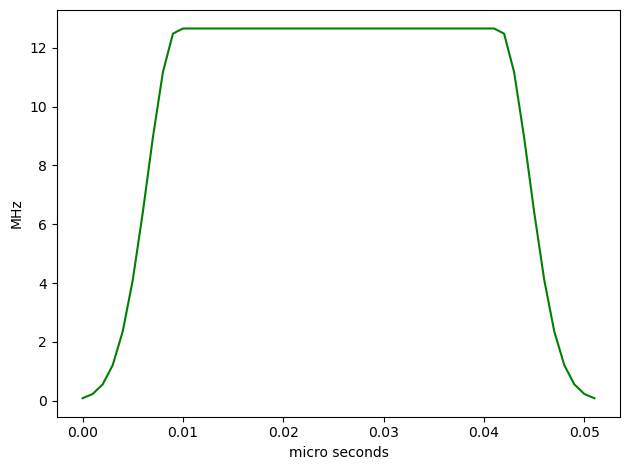

Fidelity :  0.9618448066462677


Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-2.10968927e-12+3.26067655e-05j  1.00000000e+00+8.77921016e-17j]
 [ 1.00000000e+00-1.31688152e-15j  1.63746566e-12+3.26067606e-05j]]

In [37]:
plt.plot(results.time[:-1], results.initial_amps[:,0],color = 'green')
plt.xlabel("micro seconds")
plt.ylabel('MHz')
plt.tight_layout()
plt.show()
U=results.evo_full_initial
print("Fidelity : ",1-results.initial_fid_err)
U_1=np.exp(-1j*cmath.polar(U.ptrace(0)[0][1])[1])*U.ptrace(0)/cmath.polar(U.ptrace(0)[0][1])[0]
U_1

In [163]:
1-results.initial_fid_err

0.186490035284955

In [195]:
from scipy.linalg import expm, sinm, cosm
H_c=(2*np.pi)*Qobj(a[0].dag() + a[0])/2
Qobj(expm((-500/1000)*1j*(H_c.full())))

Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.-1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]]

In [219]:
rr=[]
for i in range(10):
    for j in range(int(len(init_amps))):
        init_amps[j, 0] = ((12.6538133+i/10000000)/0.1936)*ggg[j]#p_gen.gen_pulse()
    rr.append(sum(init_amps)[0]/1000)

([<matplotlib.lines.Line2D at 0x1596ccff010>],
 [0.4999999893206679,
  0.49999999327204536,
  0.49999999722342364,
  0.500000001174802,
  0.5000000051261794,
  0.500000009077558,
  0.5000000130289355,
  0.5000000169803137,
  0.5000000209316922,
  0.5000000248830696])

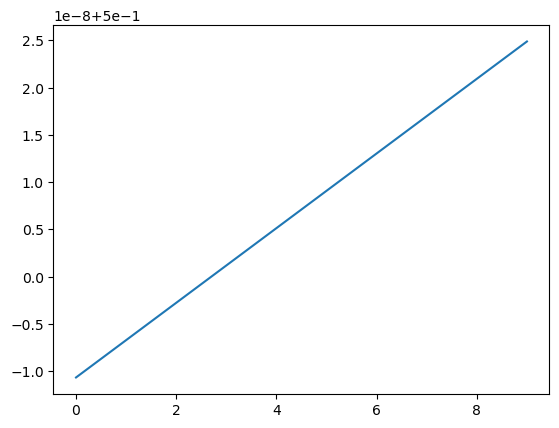

In [220]:
plt.plot(rr),rr

In [ ]:
print(results.final_amps[:,0].shape)
plt.plot(results.time[:-1], results.final_amps[:,0],color = 'black')
plt.plot(results.time[:-1], results.final_amps[:,1],color = 'green')

plt.tight_layout()
plt.show()

NameError: name 'sx' is not defined

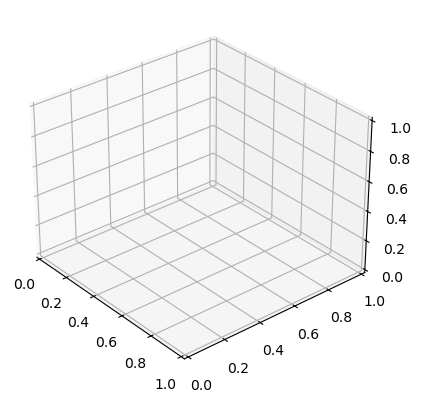

In [38]:
from matplotlib import pyplot, animation

fig = pyplot.figure()
ax = fig.add_subplot(azim=-40, elev=30, projection="3d")
sphere = qutip.Bloch(axes=ax)

def animate(i):
   sphere.clear()
   sphere.add_vectors([np.sin(theta), 0, np.cos(theta)], ["r"])
   sphere.add_points([sx[:i+1], sy[:i+1], sz[:i+1]])
   sphere.make_sphere()
   return ax

ani = animation.FuncAnimation(fig, animate, np.arange(len(sx)), blit=False, repeat=False)
ani.save('bloch_sphere.mp4', fps=20)